In [ ]:
pip install pandas opencv-python Pillow torch torchvision openpyxl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 50.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 26.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 104.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [ ]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from google.colab import files
import zipfile
import time
import gc
import cv2
import pickle
from skimage.feature import local_binary_pattern

# Step 1: Install required packages if not already installed
start_time = time.time()
try:
    import cv2
    print("OpenCV is already installed.")
except ImportError:
    print("Installing opencv-python-headless...")
    !pip install opencv-python-headless

try:
    from skimage.feature import local_binary_pattern
    print("scikit-image is already installed.")
except ImportError:
    print("Installing scikit-image...")
    !pip install scikit-image

print(f"Step 1 (package installation) completed in {time.time() - start_time:.2f} seconds")

# Step 2: Initialize SIFT detector
start_time = time.time()
sift = cv2.SIFT_create(nfeatures=500)
print("Initialized SIFT detector.")
print(f"Step 2 completed in {time.time() - start_time:.2f} seconds")

# Step 3: Feature extraction function
def extract_features(image_path):
    try:
        # SIFT features
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if image is None:
            raise ValueError("Image could not be loaded.")

        max_size = 512
        min_size = 16
        h, w = image.shape
        if max(h, w) > max_size:
            scale = max_size / max(h, w)
            new_w, new_h = int(w * scale), int(h * scale)
        else:
            new_w, new_h = w, h
        new_w = max(new_w, min_size)
        new_h = max(new_h, min_size)
        if new_w != w or new_h != h:
            image = cv2.resize(image, (new_w, new_h))

        keypoints, descriptors = sift.detectAndCompute(image, None)
        if descriptors is None:
            descriptors = np.zeros((1, 128), dtype=np.float32)
            keypoints = [cv2.KeyPoint(0, 0, 1)]
        keypoint_positions = [(kp.pt[0], kp.pt[1]) for kp in keypoints]

        # Define ROI
        h, w = image.shape
        roi_x = int(w / 4)
        roi_y = int(h / 8)
        roi_w = int(w / 2)
        roi_h = int(3 * h / 8)
        roi_w = max(1, roi_w)
        roi_h = max(1, roi_h)
        roi_x_end = min(roi_x + roi_w, w)
        roi_y_end = min(roi_y + roi_h, h)
        roi_x = max(0, roi_x)
        roi_y = max(0, roi_y)
        if roi_x_end <= roi_x or roi_y_end <= roi_y:
            roi_x, roi_y = 0, 0
            roi_x_end, roi_y_end = min(1, w), min(1, h)
        image_roi = image[roi_y:roi_y_end, roi_x:roi_x_end]

        # LBP features
        lbp = local_binary_pattern(image_roi, P=16, R=2, method='uniform')
        lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 17), density=True)

        # Color histogram
        color_image = cv2.imread(image_path)
        if color_image is None:
            raise ValueError("Color image could not be loaded.")
        color_image = cv2.resize(color_image, (new_w, new_h))
        color_image_roi = color_image[roi_y:roi_y_end, roi_x:roi_x_end]
        color_image_roi = cv2.cvtColor(color_image_roi, cv2.COLOR_BGR2HSV)
        hist = cv2.calcHist([color_image_roi], [0, 1], None, [50, 60], [0, 180, 0, 256])
        cv2.normalize(hist, hist)

        return keypoint_positions, descriptors, lbp_hist, hist.flatten()

    except Exception as e:
        print(f"Error extracting features for {image_path}: {e}")
        return [(0, 0)], np.zeros((1, 128), dtype=np.float32), np.zeros(17, dtype=np.float32), np.zeros(3000, dtype=np.float32)

# Step 4: Upload files
start_time = time.time()
print("Please upload the Excel file (e.g., 'Dataset for Image search.xlsx'):")
uploaded_excel = files.upload()
dataset_path = next((f for f in uploaded_excel if f.endswith('.xlsx')), None)

print("Please upload the ZIP file (e.g., 'CollectedImages-20250420T025610Z-001.zip'):")
uploaded_zip = files.upload()
zip_file = next((f for f in uploaded_zip if f.endswith('.zip')), None)

# Extract ZIP
extraction_directory = "/content/CollectedImages"
if not os.path.exists(extraction_directory):
    os.makedirs(extraction_directory)

with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall(extraction_directory)

images_folder = os.path.join(extraction_directory, "CollectedImages")
print(f"Images extracted to: {images_folder}")
print(f"Step 4 completed in {time.time() - start_time:.2f} seconds")

# Step 5: Load Excel dataset
start_time = time.time()
df = pd.read_excel(dataset_path)
print(f"Loaded dataset with {len(df)} rows.")
print(f"Step 5 completed in {time.time() - start_time:.2f} seconds")

# Step 6: Extract features for each image
start_time = time.time()
product_images = df['image_url_local'].apply(lambda x: os.path.join(images_folder, os.path.basename(x.replace('\\', '/')))).tolist()

all_keypoint_positions = []
all_descriptors = []
all_lbp_features = []
all_color_histograms = []
all_image_names = []

for img_path in product_images:
    if os.path.exists(img_path):
        keypoint_positions, descriptors, lbp_hist, color_hist = extract_features(img_path)
    else:
        print(f"Image not found: {img_path}")
        keypoint_positions = [(0, 0)]
        descriptors = np.zeros((1, 128), dtype=np.float32)
        lbp_hist = np.zeros(17, dtype=np.float32)
        color_hist = np.zeros(3000, dtype=np.float32)

    all_keypoint_positions.append(keypoint_positions)
    all_descriptors.append(descriptors)
    all_lbp_features.append(lbp_hist)
    all_color_histograms.append(color_hist)
    all_image_names.append(img_path)
    gc.collect()

print(f"Extracted features for {len(all_descriptors)} images.")
print(f"Step 6 completed in {time.time() - start_time:.2f} seconds")

# Step 7: Save data
start_time = time.time()
pickle.dump(all_keypoint_positions, open('/content/all_keypoint_positions.pkl', 'wb'))
pickle.dump(all_descriptors, open('/content/all_descriptors.pkl', 'wb'))
pickle.dump(all_lbp_features, open('/content/all_lbp_features.pkl', 'wb'))
pickle.dump(all_color_histograms, open('/content/all_color_histograms.pkl', 'wb'))
pickle.dump(all_image_names, open('/content/all_image_names.pkl', 'wb'))
df.to_pickle('/content/dataset_df.pkl')

print("Saved precomputed data to disk.")
print(f"Step 7 completed in {time.time() - start_time:.2f} seconds")

gc.collect()
print("Dataset preparation completed. You can now run the search script.")


OpenCV is already installed.
scikit-image is already installed.
Step 1 (package installation) completed in 0.00 seconds
Initialized SIFT detector.
Step 2 completed in 0.01 seconds
Please upload the Excel file (e.g., 'Dataset for Image search.xlsx'):


Saving Dataset for Image search.xlsx to Dataset for Image search.xlsx
Please upload the ZIP file (e.g., 'CollectedImages-20250420T025610Z-001.zip'):


Saving CollectedImages-20250420T025610Z-001.zip to CollectedImages-20250420T025610Z-001.zip
Images extracted to: /content/CollectedImages/CollectedImages
Step 4 completed in 253.37 seconds
Loaded dataset with 116 rows.
Step 5 completed in 1.48 seconds
Extracted features for 116 images.
Step 6 completed in 26.34 seconds
Saved precomputed data to disk.
Step 7 completed in 0.02 seconds
Dataset preparation completed. You can now run the search script.


Upload a query image:


Saving try1.png to try1.png

Top 5 Matched Dresses:
--------------------------------------------------

Match 1 (Score: 0.86):
  department_code: 23
  department_name: Shalwar-Kameez
  line_code: 43
  line_name: Ladies Silk/Muslin Shalwar-Kameez-Dopatta
  group_code: 4302
  group_name: Ladies Muslin Skd
  design_no: 23E244302014
  product_code: 430000119967
  product_description: H.Emb+Applique+S.P Muslin 3/4 Sl.Long PKD
  size_name: 36
  image_url_local: C:\CollectedImages\0430000119967.jpg

Match 2 (Score: 0.34):
  department_code: 15
  department_name: Panjabi
  line_code: 3
  line_name: Men Cotton Panjabee
  group_code: 352
  group_name: H.emb/app.slimfit P.lm.c.cot.men Panjabi(05/04/12)
  design_no: 15E200325052
  product_code: 30000114679
  product_description: H.emb. P.lm.c.cot.men Panjabi slimfit
  size_name: 48
  image_url_local: C:\CollectedImages\0030000114675.jpg

Match 3 (Score: 0.32):
  department_code: 15
  department_name: Panjabi
  line_code: 3
  line_name: Men Cotton 

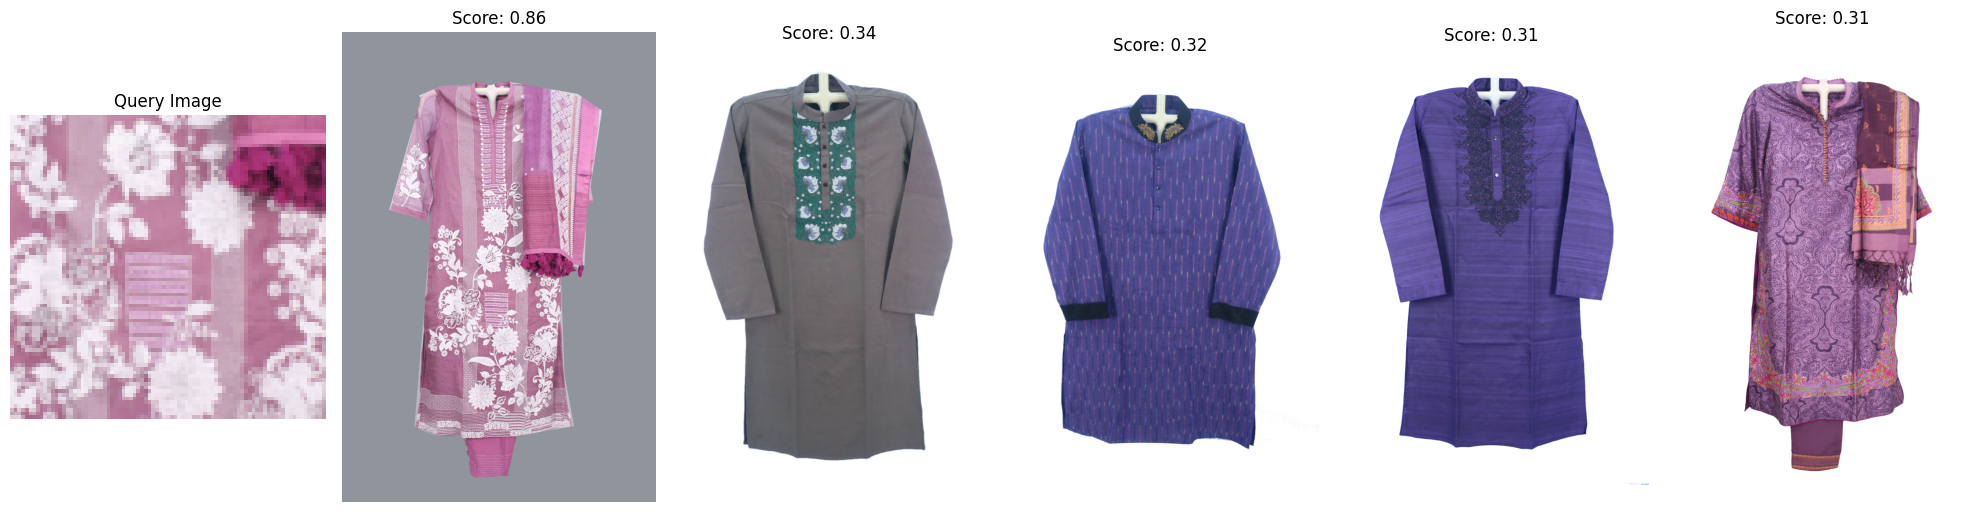

In [ ]:
import os
import numpy as np
import pickle
import cv2
from skimage.feature import local_binary_pattern
from sklearn.metrics.pairwise import cosine_similarity
from google.colab import files
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd

# Load precomputed features
keypoint_positions = pickle.load(open('/content/all_keypoint_positions.pkl', 'rb'))
descriptors = pickle.load(open('/content/all_descriptors.pkl', 'rb'))
lbp_features = pickle.load(open('/content/all_lbp_features.pkl', 'rb'))
color_histograms = pickle.load(open('/content/all_color_histograms.pkl', 'rb'))
image_paths = pickle.load(open('/content/all_image_names.pkl', 'rb'))

# Load the dataset DataFrame
df = pd.read_pickle('/content/dataset_df.pkl')

# Load SIFT
sift = cv2.SIFT_create(nfeatures=500)

# Upload a query image
print("Upload a query image:")
uploaded = files.upload()
query_image_path = next(iter(uploaded))

# Extract features for query image
def extract_query_features(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    h, w = image.shape
    max_size = 512
    scale = min(max_size / max(h, w), 1.0)
    new_w, new_h = int(w * scale), int(h * scale)
    image = cv2.resize(image, (new_w, new_h))
    keypoints, desc = sift.detectAndCompute(image, None)
    if desc is None:
        desc = np.zeros((1, 128), dtype=np.float32)

    # ROI for LBP and color
    roi_x = int(new_w / 4)
    roi_y = int(new_h / 8)
    roi_w = int(new_w / 2)
    roi_h = int(3 * new_h / 8)
    image_roi = image[roi_y:roi_y+roi_h, roi_x:roi_x+roi_w]

    # LBP features
    lbp = local_binary_pattern(image_roi, P=16, R=2, method='uniform')
    lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 17), density=True)

    # Color histogram
    color_image = cv2.imread(image_path)
    color_image = cv2.resize(color_image, (new_w, new_h))
    color_roi = color_image[roi_y:roi_y+roi_h, roi_x:roi_x+roi_w]
    color_roi = cv2.cvtColor(color_roi, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([color_roi], [0, 1], None, [50, 60], [0, 180, 0, 256])
    cv2.normalize(hist, hist)

    return desc, lbp_hist, hist.flatten()

query_desc, query_lbp, query_color = extract_query_features(query_image_path)

# Step: Compute similarities
def compute_similarity(query_desc, query_lbp, query_color, descriptors, lbp_features, color_histograms):
    sift_sims = []
    for desc in descriptors:
        if desc.shape[0] == 0:
            sift_sims.append(0)
            continue
        bf = cv2.BFMatcher()
        matches = bf.knnMatch(query_desc, desc, k=2)
        good = [m for m, n in matches if m.distance < 0.75 * n.distance]
        sim_score = len(good) / (len(query_desc) + 1e-6)
        sift_sims.append(sim_score)

    # Normalize SIFT scores (Fixed typo: silt_sims -> sift_sims)
    sift_sims = np.array(sift_sims)
    sift_sims = (sift_sims - sift_sims.min()) / (sift_sims.max() - sift_sims.min() + 1e-6)

    lbp_sims = cosine_similarity([query_lbp], lbp_features)[0]
    color_sims = cosine_similarity([query_color], color_histograms)[0]

    total_scores = 0.4 * sift_sims + 0.3 * lbp_sims + 0.3 * color_sims
    return total_scores

# Get scores
scores = compute_similarity(query_desc, query_lbp, query_color,
                            descriptors, lbp_features, color_histograms)

# Get top 5 similar images
top_indices = np.argsort(scores)[::-1][:5]

# Function to map image paths to DataFrame rows
def get_dress_details(image_path, df, images_folder):
    # Extract the image filename from the path
    image_name = os.path.basename(image_path)
    # Normalize the image_url_local column to match the image_name
    df['image_filename'] = df['image_url_local'].apply(lambda x: os.path.basename(x.replace('\\', '/')))
    # Find the matching row
    match = df[df['image_filename'] == image_name]
    if not match.empty:
        return match.iloc[0].to_dict()
    else:
        return {"image_name": image_name, "details": "No details found"}

# Display results and print dress details
def show_top_matches(query_path, top_indices, image_paths, scores, df, images_folder):
    fig, axs = plt.subplots(1, 6, figsize=(20, 5))
    axs[0].imshow(Image.open(query_path))
    axs[0].set_title("Query Image")
    axs[0].axis('off')

    print("\nTop 5 Matched Dresses:")
    print("-" * 50)
    for i, idx in enumerate(top_indices):
        img = Image.open(image_paths[idx])
        axs[i+1].imshow(img)
        axs[i+1].set_title(f"Score: {scores[idx]:.2f}")
        axs[i+1].axis('off')

        # Get dress details
        dress_details = get_dress_details(image_paths[idx], df, images_folder)
        print(f"\nMatch {i+1} (Score: {scores[idx]:.2f}):")
        for key, value in dress_details.items():
            if key != 'image_filename':  # Skip internal mapping column
                print(f"  {key}: {value}")

    plt.tight_layout()
    plt.show()

# Assuming images_folder from the first script
images_folder = "/content/CollectedImages/CollectedImages"
show_top_matches(query_image_path, top_indices, image_paths, scores, df, images_folder)